# State-space tutorial

$$
\newcommand{\bx}{\mathbf{x}}
\newcommand{\by}{\mathbf{y}}
\newcommand{\bz}{\mathbf{z}}
\newcommand{\bb}{\mathbf{b}}
\newcommand{\bd}{\mathbf{d}}
\newcommand{\bu}{\mathbf{u}}
\newcommand{\bbeta}{\boldsymbol{\beta}}
\newcommand{\bzeta}{\boldsymbol{\zeta}}
\newcommand{\btheta}{\boldsymbol{\theta}}
\newcommand{\bmu}{\boldsymbol{\mu}}
\newcommand{\bxi}{\boldsymbol{\xi}}
\newcommand{\Gauss}{\mathcal{N}}
\newcommand{\diff}{{\rm d}}
\newcommand{\calQ}{\mathcal{Q}}
\newcommand{\EE}{\mathbb{E}}
$$

In this tutorial, we attempt to model a damped spring mass system with the state-space frame work. 

## The physical system

The governing ordinary differential equations (ODEs) of such as system are 
$$
\frac{\diff^2 x}{\diff t^2} = - \frac{k}{m}x - \frac{b}{m}\frac{\diff x}{\diff t}.
$$
We have
- $x$: position of the mass [m]
- $k$: spring constant [N/m]
- $m$: mass [kg]
- $b$: damping coefficent [kg/s]

## Translating the system into the state space frame work

### State model

We know, that we can translate any higher-order ODEs to a system of first order ODEs. We do this here as well by 
modelling the velocity $v=\frac{\diff x}{\diff t}$, explicitely. This gives us the system
$$
\begin{align}
    \frac{\diff x}{\diff t} = & v \\
    \frac{\diff v}{\diff t} = & - \frac{k}{m}x - \frac{b}{m}v.
\end{align}
$$
We will model the system in discrete time at time-steps of sice $\Delta t$. Hence we can write the euler scheme
$$
    \begin{pmatrix}
    x_{t+1} \\
    v_{t+1}
    \end{pmatrix}
    = 
    \begin{pmatrix}
    x_{t} \\
    v_{t}
    \end{pmatrix}
    +  
    \Delta t  
    \begin{pmatrix}
        0 & 1 \\
        - \frac{k}{m} & - \frac{b}{m}
    \end{pmatrix}
    \begin{pmatrix}
    x_{t} \\
    v_{t}
    \end{pmatrix}
    = 
    \begin{pmatrix}
        1 & \Delta t \\
        - \frac{k\Delta t}{m} & 1 - \frac{b\Delta t}{m}
    \end{pmatrix}
    \begin{pmatrix}
    x_{t} \\
    v_{t}
    \end{pmatrix}
$$

Looking at the form of a discrete-time linear state-space model we see that by defining our state $\bz=(x, v)^\top$ and
$A= \begin{pmatrix}
        1 & \Delta t \\
        - \frac{k\Delta t}{m} & 1 - \frac{b\Delta t}{m}
    \end{pmatrix}
$
we have a state equation
$$
\bz_{t+1} = A\bz_t
$$
We call $A$ subsequently the *state matrix*. Note, that there is no noise in this equation.

### Noise observations

In the state space framework, we often assume, that we do not observe the state directly, but only a noise version $\by$
 of it. Hence, we assume the following observation model:
 $$
 \by_t = \bz_t + \xi_t,
 $$
 where the we have the Gaussian noise $\xi_t\sim\Gauss(0,\Sigma_y)$.

### Excercise 1: Coding the generative model

Now, we have everything in place to implement a simulator.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

T_sim = 10 # total time [s]
spring_constant = 10. # spring constant [N/m]
damping_coefficient = .5 # damping coefficient [kg/s]
mass = 1 # mass [kg]
noise_std = 0.5 # standard deviation of noise
dt = 0.01 # time step [s]
z0 = np.array([1., 0.]) # initial state [pos, vel]

state_mat = np.array([[1, dt], 
                      [-dt*(spring_constant/mass), 1. - dt*damping_coefficient/mass]])

def euler_step(z_t: np.ndarray) -> tuple[np.ndarray]:
    """ Euler step for a damped mass-spring system

    Args:
        z_t: State vector [pos, vel]
        dt: time step

    Returns:
        z_new: Updated state vector
        y: Noisy observation
    """
    # state update
    z_new = np.dot(state_mat, z_t)
    # noisy observation
    y = z_t + noise_std * np.random.randn(*z_t.shape)
    return z_new, y

### Exercise 1: Solution

```python
state_mat = np.array([[1, dt], 
                      [-dt*(spring_constant/mass), 1. - dt*damping_coefficient/mass]])

def euler_step(z_t: np.ndarray) -> tuple[np.ndarray]:
    """ Euler step for a damped mass-spring system

    Args:
        z_t: State vector [pos, vel]
        dt: time step

    Returns:
        z_new: Updated state vector
        y: Noisy observation
    """
    # state update
    z_new = np.dot(state_mat, z_t)
    # noisy observation
    y = z_t + noise_std * np.random.randn(*z_t.shape)
    return z_new, y
```

### Data generation and plotting

The following code runs the state-space model and plots the data.

Text(0, 0.5, 'Velocity [m/s]')

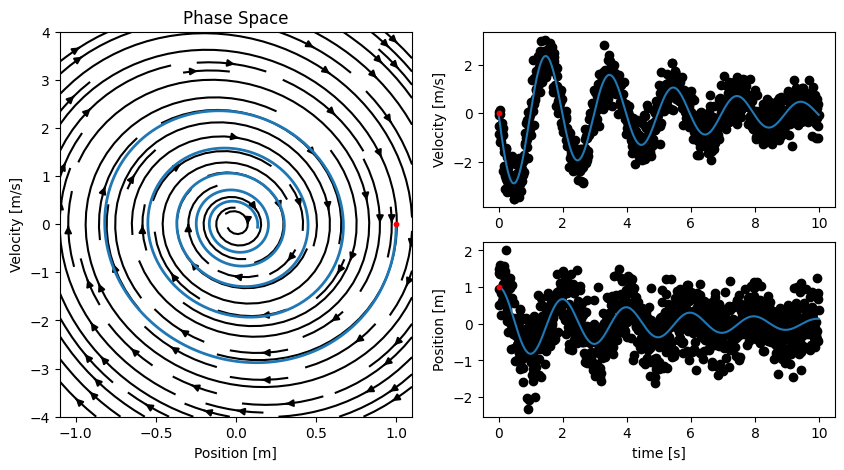

In [2]:
# Simulate
t = np.arange(0, T_sim, dt)
z = np.zeros((len(t) + 1, 2))
y = np.zeros((len(t), 2))
z[0] = z0
for i in range(1, len(t)+1):
    z[i], y[i-1] = euler_step(z[i-1])
z = z[:-1]
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(224)

x_mesh = np.linspace(-1.1, 1.1, 20)
y_mesh = np.linspace(-4, 4, 20)
X, Y = np.meshgrid(x_mesh, y_mesh)
U = Y
V = -damping_coefficient/mass * Y - (spring_constant/mass) * X

ax1.streamplot(X, Y, U, V, color='k')
ax1.plot(z[:, 0], z[:, 1], 'C0-', lw=2, label='phase space trajectory')
ax1.scatter(z[0, 0], z[0, 1], c='r', s=10, label='start', zorder=10)
ax1.set_xlabel('Position [m]')
ax1.set_ylabel('Velocity [m/s]')

ax1.set_title('Phase Space')
ax2.plot(t, y[:, 1], 'ko', label='theta(t)')
ax2.plot(t, z[:, 1], 'C0-', label='theta(t)')
ax2.scatter(t[0], z[0, 1], c='r', s=10, label='start', zorder=10)
ax3.set_ylabel('Position [m]')
ax3.plot(t, y[:, 0], 'ko', label='theta(t)')
ax3.plot(t, z[:, 0], 'C0-', label='theta(t)')
ax3.scatter(t[0], z[0, 0], c='r', s=10, label='start', zorder=10)
ax3.set_xlabel('time [s]')
ax2.set_ylabel('Velocity [m/s]')

## Data-driven state-estimation with the Kalman Filter

Now, that we have the underlying model and data, we will turn to the data-driven side. In a true scenario, we often do 
not have access to the true model. So let's assume we have one, that is misspecified

$$
\begin{align}
\bz_{t+1} = & \bz_{t} + \zeta_{t}\\
\by_{t} = & \bz_{t} + \xi_{t}
\end{align}
$$

We define the model and call the model parameters with subscript `_est`, which stands for estimated (even though it is
not at this point).

In [3]:
# State model
state_mat_est = np.eye(2)       # model state transition matrix
state_offset_est = np.zeros(2)  # model state offset
Sigma_z_est = 1e-3 * np.eye(2)  # model state noise covariance
# Observation model
observation_mat_est = np.eye(2)         # observation matrix       
observation_offset_est = np.zeros(2)    # observation offset
Sigma_x_est = noise_std ** 2 * np.eye(2)# observation noise covariance

### Excercise 2a: Implementing the Kalman Filter

Next, we want to implement the Kalman Filter for this model. Go back to the slides, and check out the two steps that we
need to perform at each time-step and try to implement them.

In [4]:
def predict_step(mu: np.ndarray, Sigma: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """ Predict the next state of the system.

    Args:
        mu: Mean of the state.
        Sigma: Covariance of the state.

    Returns:
        mu_tilde: Predicted mean of the state.
        Sigma_tilde: Predicted covariance of the state.
    """
    mu_tilde = np.dot(state_mat_est, mu) + state_offset_est
    Sigma_tilde = Sigma_z_est + np.dot(state_mat_est, np.dot(Sigma, state_mat_est.T))
    return mu_tilde, Sigma_tilde

def filter_step(y: np.ndarray, mu_tilde: np.ndarray, Sigma_tilde: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """ Update the state estimate given the observation.

    Args:
        y: Observation
        mu_tilde: Predicted mean of the state.
        Sigma_tilde: Predicted covariance of the state.

    Returns:
        mu: Updated mean of the state.
        Sigma: Updated covariance of the state.
    """
    K = Sigma_x_est + np.dot(observation_mat_est, np.dot(Sigma_tilde, observation_mat_est.T))
    K_inv = np.linalg.inv(K)
    kalman_gain = np.dot(Sigma_tilde, np.dot(observation_mat_est.T, K_inv))
    pred_err = y - np.dot(observation_mat_est, mu_tilde) - observation_offset_est
    mu = mu_tilde + np.dot(kalman_gain, pred_err)
    Sigma = Sigma_tilde - np.dot(kalman_gain, np.dot(observation_mat_est, Sigma_tilde))
    return mu, Sigma

### Exercise 2a: Solution

```python
def predict_step(mu: np.ndarray, Sigma: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """ Predict the next state of the system.

    Args:
        mu: Mean of the state.
        Sigma: Covariance of the state.

    Returns:
        mu_tilde: Predicted mean of the state.
        Sigma_tilde: Predicted covariance of the state.
    """
    mu_tilde = np.dot(state_mat_est, mu) + state_offset_est
    Sigma_tilde = Sigma_z_est + np.dot(state_mat_est, np.dot(Sigma, state_mat_est.T))
    return mu_tilde, Sigma_tilde

def filter_step(y: np.ndarray, mu_tilde: np.ndarray, Sigma_tilde: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """ Update the state estimate given the observation.

    Args:
        y: Observation
        mu_tilde: Predicted mean of the state.
        Sigma_tilde: Predicted covariance of the state.

    Returns:
        mu: Updated mean of the state.
        Sigma: Updated covariance of the state.
    """
    K = Sigma_x_est + np.dot(observation_mat_est, np.dot(Sigma_tilde, observation_mat_est.T))
    K_inv = np.linalg.inv(K)
    kalman_gain = np.dot(Sigma_tilde, np.dot(observation_mat_est.T, K_inv))
    pred_err = y - np.dot(observation_mat_est, mu_tilde) - observation_offset_est
    mu = mu_tilde + np.dot(kalman_gain, pred_err)
    Sigma = Sigma_tilde - np.dot(kalman_gain, np.dot(observation_mat_est, Sigma_tilde))
    return mu, Sigma
```

If you have the correct solution, you should find that the state is tract quite accurately.

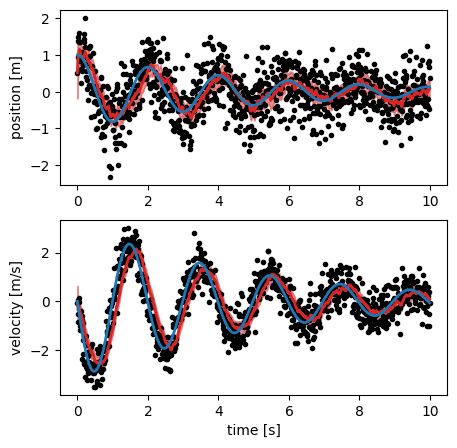

In [5]:
mu_tilde = y[0]
Sigma_tilde = noise_std ** 2 * np.eye(2)

T = len(t)
mu = np.zeros((T, 2))
Sigma = np.zeros((T, 2, 2))

for i in range(T):
    mu[i], Sigma[i] = filter_step(y[i], mu_tilde, Sigma_tilde)
    mu_tilde, Sigma_tilde = predict_step(mu[i], Sigma[i])
    
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(t, y[:, 0], 'k.', label='observed trajectory')
ax1.plot(t, mu[:, 0], 'C3-', lw=2, label='kalman filter')
ax1.fill_between(t, mu[:, 0] - 2 * np.sqrt(Sigma[:, 0, 0]), mu[:, 0] + 2 * np.sqrt(Sigma[:, 0, 0]), color='C3', alpha=0.5)
ax1.plot(t, z[:, 0], 'C0-', lw=2, label='true trajectory')
ax1.set_ylabel('position [m]')

ax2.plot(t, y[:, 1], 'k.', label='observed trajectory')
ax2.plot(t, mu[:, 1], 'C3-', lw=2, label='kalman filter')
ax2.fill_between(t, mu[:, 1] - 2 * np.sqrt(Sigma[:, 1, 1]), mu[:, 1] + 2 * np.sqrt(Sigma[:, 1, 1]), color='C3', alpha=0.5)
ax2.plot(t, z[:, 1], 'C0-', lw=2, label='true trajectory')
ax2.set_ylabel('velocity [m/s]')
ax2.set_xlabel('time [s]')
plt.show()

### Exercise 2b

Now assume, we have no data anymore after `T_obs`, i.e. we cannot perform the filtering step after this time point. Modify the code below, such that the state is not 

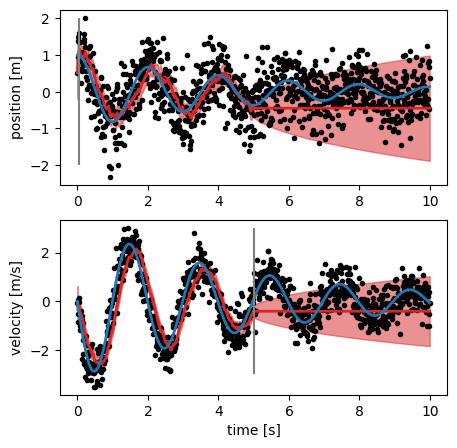

In [6]:
T_obs = T_sim // 2
mu_tilde = y[0]
Sigma_tilde = noise_std ** 2 * np.eye(2)

mu = np.zeros((T, 2))
Sigma = np.zeros((T, 2, 2))

for i in range(T):
    if t[i] < T_obs:
        mu[i], Sigma[i] = filter_step(y[i], mu_tilde, Sigma_tilde)
        mu_tilde, Sigma_tilde = predict_step(mu[i], Sigma[i])
    else:
        mu[i], Sigma[i] = predict_step(mu[i-1], Sigma[i-1])
    
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(t, y[:, 0], 'k.', label='observed trajectory')
ax1.plot(t, mu[:, 0], 'C3-', lw=2, label='kalman filter')
ax1.fill_between(t, mu[:, 0] - 2 * np.sqrt(Sigma[:, 0, 0]), mu[:, 0] + 2 * np.sqrt(Sigma[:, 0, 0]), color='C3', alpha=0.5)
ax1.plot(t, z[:, 0], 'C0-', lw=2, label='true trajectory')
ax1.vlines(t[T_obs], -2, 2, color='gray', label='prediction start')
ax1.set_ylabel('position [m]')
#ax1.plot(x[:, 0], x[:, 1], 'r-', label='true trajectory')

ax2.plot(t, y[:, 1], 'k.', label='observed trajectory')
ax2.plot(t, mu[:, 1], 'C3-', lw=2, label='kalman filter')
ax2.fill_between(t, mu[:, 1] - 2 * np.sqrt(Sigma[:, 1, 1]), mu[:, 1] + 2 * np.sqrt(Sigma[:, 1, 1]), color='C3', alpha=0.5)
ax2.plot(t, z[:, 1], 'C0-', lw=2, label='true trajectory')
ax2.vlines(T_obs, -3, 3, color='gray', label='prediction start')
ax2.set_ylabel('velocity [m/s]')
ax2.set_xlabel('time [s]')
#ax2.legend()
plt.show()

### Exercise 2b: Solution

```python
T_obs = T_sim // 2
mu_tilde = y[0]
Sigma_tilde = noise_std ** 2 * np.eye(2)

mu = np.zeros((T, 2))
Sigma = np.zeros((T, 2, 2))

for i in range(T):
    if t[i] < T_obs:
        mu[i], Sigma[i] = filter_step(y[i], mu_tilde, Sigma_tilde)
        mu_tilde, Sigma_tilde = predict_step(mu[i], Sigma[i])
    else:
        mu[i], Sigma[i] = predict_step(mu[i-1], Sigma[i-1])
    
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(t, y[:, 0], 'k.', label='observed trajectory')
ax1.plot(t, mu[:, 0], 'C3-', lw=2, label='kalman filter')
ax1.fill_between(t, mu[:, 0] - 2 * np.sqrt(Sigma[:, 0, 0]), mu[:, 0] + 2 * np.sqrt(Sigma[:, 0, 0]), color='C3', alpha=0.5)
ax1.plot(t, z[:, 0], 'C0-', lw=2, label='true trajectory')
ax1.vlines(t[T_obs], -2, 2, color='gray', label='prediction start')
ax1.set_ylabel('position [m]')
#ax1.plot(x[:, 0], x[:, 1], 'r-', label='true trajectory')

ax2.plot(t, y[:, 1], 'k.', label='observed trajectory')
ax2.plot(t, mu[:, 1], 'C3-', lw=2, label='kalman filter')
ax2.fill_between(t, mu[:, 1] - 2 * np.sqrt(Sigma[:, 1, 1]), mu[:, 1] + 2 * np.sqrt(Sigma[:, 1, 1]), color='C3', alpha=0.5)
ax2.plot(t, z[:, 1], 'C0-', lw=2, label='true trajectory')
ax2.vlines(T_obs, -3, 3, color='gray', label='prediction start')
ax2.set_ylabel('velocity [m/s]')
ax2.set_xlabel('time [s]')
#ax2.legend()
plt.show()
```

## Learning the state-space model with expectation maximization

We saw, that the state predictions are quite bad, when we do not observe the data anymore. So let's try to learn the 
state-space model from the data until we observe. To this end, we use the [`pykalman`](https://github.com/pykalman/pykalman) library, which uses the 
expectation maximization (EM) algorithm to learn the model. Check slides for the details.

In [7]:
from pykalman import KalmanFilter

t_idx_pred = np.searchsorted(t, T_obs)

# Here we initialize the state space model
kf = KalmanFilter(transition_matrices=state_mat_est,
                    observation_matrices=observation_mat_est,
                    transition_covariance=Sigma_z_est,
                    observation_covariance=Sigma_x_est,
                    transition_offsets=state_offset_est,
                    observation_offsets=observation_offset_est)

# We estimate the parameters of the model, but only the covariance matrices and the matrix.
kf = kf.em(y[:t_idx_pred], n_iter=50, em_vars=['transition_covariance', 'observation_covariance', 'transition_matrices'])

state_mat_est = kf.transition_matrices
state_offset_est = kf.transition_offsets
Sigma_z_est = kf.transition_covariance
observation_mat_est = kf.observation_matrices
observation_offset_est = kf.observation_offsets
Sigma_x_est = kf.observation_covariance

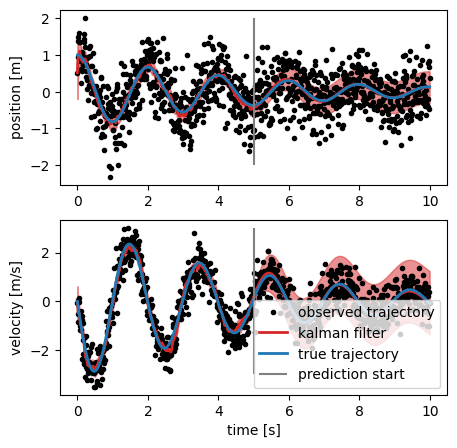

In [8]:
mu_tilde = y[0]
Sigma_tilde = noise_std ** 2 * np.eye(2)

T = len(t)
mu = np.zeros((T, 2))
Sigma = np.zeros((T, 2, 2))

for i in range(T):
    if t[i] < T_obs:
        mu[i], Sigma[i] = filter_step(y[i], mu_tilde, Sigma_tilde)
        mu_tilde, Sigma_tilde = predict_step(mu[i], Sigma[i])
    else:
        mu[i], Sigma[i] = predict_step(mu[i-1], Sigma[i-1])
    
    
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(t, y[:, 0], 'k.', label='observed trajectory')
ax1.plot(t, mu[:, 0], 'C3-', lw=2, label='kalman filter')
ax1.fill_between(t, mu[:, 0] - 2 * np.sqrt(Sigma[:, 0, 0]), mu[:, 0] + 2 * np.sqrt(Sigma[:, 0, 0]), color='C3', alpha=0.5)
ax1.plot(t, z[:, 0], 'C0-', lw=2, label='true trajectory')
ax1.vlines(T_obs, -2, 2, color='gray', label='prediction start')
ax1.set_ylabel('position [m]')
#ax1.plot(x[:, 0], x[:, 1], 'r-', label='true trajectory')

ax2.plot(t, y[:, 1], 'k.', label='observed trajectory')
ax2.plot(t, mu[:, 1], 'C3-', lw=2, label='kalman filter')
ax2.fill_between(t, mu[:, 1] - 2 * np.sqrt(Sigma[:, 1, 1]), mu[:, 1] + 2 * np.sqrt(Sigma[:, 1, 1]), color='C3', alpha=0.5)
ax2.plot(t, z[:, 1], 'C0-', lw=2, label='true trajectory')
ax2.vlines(T_obs, -3, 3, color='gray', label='prediction start')
ax2.set_ylabel('velocity [m/s]')
ax2.set_xlabel('time [s]')
ax2.legend()
plt.show()

This should look now much better. You should see, that the model is capturing the damped oscillations of the system. 

Optional: Check whether the phase space is recovered with the new model.

## Control: The linear quadratic regulator

Now we want to connect to the last lectures. With the learned model from before, we would like to bring the system to 
stillness. Our control variable is force, we can apply to the mass. Since force is directly related to acceleration, our 
system of ODEs from earlier change as follows
$$
\begin{align}
    \frac{\diff x}{\diff t} = & v \\
    \frac{\diff v}{\diff t} = & - \frac{k}{m}x - \frac{b}{m}v + \textcolor{red}{\frac{1}{m}u},
\end{align}
$$
where $u$ is the force we apply to the mass, and it will b our control variable.
In the discrete time linear system, we obtain
$$
    \begin{pmatrix}
    x_{t+1} \\
    v_{t+1}
    \end{pmatrix}
    = 
    \begin{pmatrix}
        1 & \Delta t \\
        - \frac{k\Delta t}{m} & 1 - \frac{b\Delta t}{m}
    \end{pmatrix}
    \begin{pmatrix}
    x_{t} \\
    v_{t}
    \end{pmatrix}
    +
    \textcolor{red}{
    \begin{pmatrix}
        0 \\
        \frac{\Delta t}{m}
    \end{pmatrix}
    u
    }
$$
The last term is the includes a control vector, that determines how our control variable effects the space.

### Data-driven control

Since we want to put everything together in this section, we want to use the model, we previously estimated with EM,
for planning the control. Then we will see whether the (optimal) contol for the estimated model helps also for 
controlling the true physical system.

So the state equation that we learnt combined with the control is
$$
\bz_{t+1} = A_{\rm est}\bz_t + \textcolor{red}{
    \begin{pmatrix}
        0 \\
        \frac{\Delta t}{m}
    \end{pmatrix}
    u
}.
$$
Note, that we ignore the noise term of the state equation for planning, for making it easier. In fact, this will not 
change the end result, since the optimal control for the system without noise turns out to be optimal for the noisy 
system as well. CAUTION: This is only true, because we consider the linear case, with Gaussian additive noise.

### Defining the cost

To achieve the goal to bring the mass to stillness we choose a quadratic cost function with a finite horizon $H$, 
which we want to minimize
$$
    \text{min} \sum_{t=0}^{H-1}\bz_t^\top Q\bz_t + \bu_t^\top R\bu_t\quad \text{with} \quad Q=Q^\top\succeq 0, R=R^\top\succeq 0
$$
As on the slides we choose a linear Ansatz for the control:
$$
\bu_t=\tilde{K}_t\hat{\bz},
$$
where $\hat{\bz}$ is the initial state.
Following the derivations of the slides we get the following result for the optimal control
$$
\tilde{K}_t = -\left(\sum_{i=t+1}^{H-1}(A_{\rm est}^i)^\top Q A_{\rm est}^{i-t-1}B\right)\left(R + \sum_{i=t+1}^{H-1}B^\top(A_{\rm est}^{i-t-1})^\top QA_{\rm est}^{i-t-1}B\right)^{-1}.
$$

So let's define the new components we need, namely the control vector, the matrices in the cost function $Q,R$, and the horizon $H$. 

In [9]:
R = np.eye(2)
Q = np.eye(2)
control_mat = np.array([[0], [dt / mass]])
horizon = 100

### Exercise 3: Implement the LQR

Implement the optimal LQR controller for the estimated system. $A_est$ is `state_mat_est`.

In [10]:
def get_optimal_control(t, init_state):
    mat1 = np.copy(R)
    mat2 = 0
    for i in range(t+1, horizon):
        pow_mat1 = np.linalg.matrix_power(state_mat_est, i-t-1)
        mat1 += control_mat.T @ pow_mat1.T @ Q @ pow_mat1 @ control_mat
        pow_mat2 = np.linalg.matrix_power(state_mat_est, i)
        mat2 -= pow_mat2.T @ Q @ pow_mat1 @ control_mat
    K_tilde = np.linalg.solve(mat1, mat2).T
    return  K_tilde @ init_state

def state_model(z_t: np.ndarray, control: bool=False) -> np.ndarray:
    """ State model for a damped mass-spring system

    Args:
        z_t: State vector [pos, vel]
        dt: time step
        
    Returns:
        z_new: State vector at time t+dt
    """
    if control:
        u_new = get_optimal_control(0, z_t)
    else:
        u_new = np.zeros(1)
    z_new = np.dot(state_mat, z_t) + np.dot(control_mat, u_new)
    return z_new, u_new

### Exercise 3: Solution

```python
def get_optimal_control(t, init_state):
    mat1 = np.copy(R)
    mat2 = 0
    for i in range(t+1, horizon):
        pow_mat1 = np.linalg.matrix_power(state_mat_est, i-t-1)
        mat1 += control_mat.T @ pow_mat1.T @ Q @ pow_mat1 @ control_mat
        pow_mat2 = np.linalg.matrix_power(state_mat_est, i)
        mat2 -= pow_mat2.T @ Q @ pow_mat1 @ control_mat
    K_tilde = np.linalg.solve(mat1, mat2).T
    return  K_tilde @ init_state

def state_model(z_t: np.ndarray, control: bool=False) -> np.ndarray:
    """ State model for a damped mass-spring system

    Args:
        z_t: State vector [pos, vel]
        dt: time step
        
    Returns:
        z_new: State vector at time t+dt
    """
    if control:
        u_new = get_optimal_control(0, z_t)
    else:
        u_new = np.zeros(1)
    z_new = np.dot(state_mat, z_t) + np.dot(control_mat, u_new)
    return z_new, u_new
```

Now we run the __true__ state equation with the control, we got from the inferred model, and as a reference we check the system running without control.

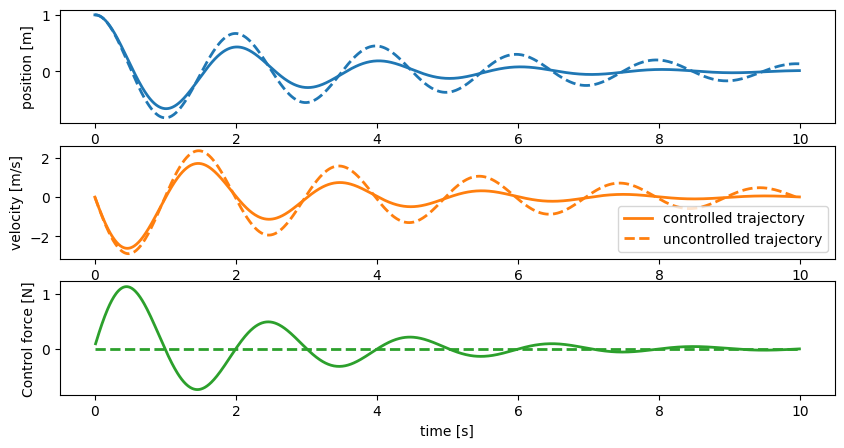

In [11]:
z_controlled = np.zeros((len(t), 2))
z_uncontrolled = np.zeros((len(t), 2))
u = np.zeros((len(t), 1))
z_controlled[0] = z0
z_uncontrolled[0] = z0
for i in range(1, len(t)):
    z_controlled[i], u[i] = state_model(z_controlled[i-1], control=True)
    z_uncontrolled[i], _ = state_model(z_uncontrolled[i-1], control=False)

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(311)
ax1.plot(t, z_controlled[:, 0], 'C0-', lw=2, label='true trajectory')
ax1.plot(t, z_uncontrolled[:, 0], 'C0--', lw=2, label='uncontrolled trajectory')
ax1.set_ylabel('position [m]')
ax2 = fig.add_subplot(312)
ax2.plot(t, z_controlled[:, 1], 'C1-', lw=2, label='controlled trajectory')
ax2.plot(t, z_uncontrolled[:, 1], 'C1--', lw=2, label='uncontrolled trajectory')
plt.legend()
ax2.set_ylabel('velocity [m/s]')
ax3 = fig.add_subplot(313)
ax3.plot(t, np.zeros_like(t), 'C2--', lw=2, label='control input')
ax3.plot(t[1:], u[1:], 'C2-', lw=2, label='control input')
ax3.set_ylabel('Control force [N]')
ax3.set_xlabel('time [s]')
plt.show()


We see, that the control force tries to counteract the velocity of the mass, which is very intuitive. Also we see, that oscillations of the controlled system fade out much quicker.

Optional: Try to incorporate a non-zero target trajectory.

## Concluding remarks

In this tutorial we have seen how to
- translate a physical system into a state-space model
- Use the Kalman-Filter for robust state estimation even under model specification.
- To learn the state-space model based on data with expectation maximization
- How to incorporate control in the system

Note, that this was a very educational example, where we know the system quite well, and everything is nicely linear.
In nowadays applications, sometimes the states $\bz$ have not a straightforward interpretation, since the models are 
learnt based on data, and they are highly non-linear. 

This tutorial, however, set the basis and you are now ready to 
dive into the powerful, but complext world of non-linear, data-driven, deep state-space models.